# 识别坏导后应用MaxFilter


## 引言
本节的目的是演示“麦克斯韦滤波”的应用，也称为信号空间分离（SSS）。称为MaxFilter的实现用于减少来自环境源和传感器噪声的伪影。该程序还执行一些微调，并减少位于同一位置的传感器之间的串扰。在应用MaxFilter算法之前，建议移除“坏”传感器，即扁平或有过多伪影的传感器。如果不这样做，可能会导致故障传感器产生的伪影被分配给其他传感器。

具体而言，SSS是一种源自麦克斯韦方程定义的电磁学物理学的技术（Taulu和Kajola，2005年；Taulu and Simola，2006年）。该算法将测量信号分离为分别归属于MEG传感器阵列内部和外部的源的分量。由于内部和外部分量是线性独立的，因此可以抑制来自外部分量的贡献，从而减少环境噪声源。该过程还省略了由噪声主导的高阶分量。

## 准备
首先加载相关的Python模块：

In [3]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
import matplotlib
import matplotlib.pyplot as plt
import scipy
matplotlib.use('TKAgg')

### File overview
The chapter relies on the input files:

~~~
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_meg.fif
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_acq-calibration_meg.dat
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_acq-crosstalk_meg.fif
~~~
and generates the output files
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
~~~

Define path to the local data and then define the file names:

In [4]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '02'

bids_root = '/home/ubuntu/database/ds004346-FLUX'

bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix='meg', extension='.fif', root=bids_root)

deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix='meg', root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace('meg', 'raw_sss') # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')

现在定义校准和串扰文件。这些文件包含与传感器方向和校准相关的特定地点信息。如果找不到，请咨询当地专家。串扰补偿文件包含用于减少位于同一位置的磁力计和成对梯度计传感器单元之间的干扰的参数。校准文件包含特定于局部静态磁场和梯度的信息。请注意，校准文件将特定于MEG系统的位置（龙门架的角度）。在这种情况下，龙门架角度为68度（请参阅“首次查看数据”）。

In [5]:
crosstalk_file = bids_path.meg_crosstalk_fpath
calibration_file = bids_path.meg_calibration_fpath
print(crosstalk_file)
print(calibration_file)

/home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_acq-crosstalk_meg.fif
/home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_acq-calibration_meg.dat


Now read the raw data:

In [6]:
raw1 = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file /home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_meg.fif...
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Reading events from /home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_events.tsv.
Reading channel info from /home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_channels.tsv.
Dropping cHPI information stored in raw data

### 识别坏导
下面的脚本可以自动识别坏导：

In [ ]:
raw1.info['bads'] = []
raw1_copy = raw1.copy()  # copy to make sure we are not overwriting the raw data
auto_noisy_chs, auto_flat_chs, auto_scores = mne.preprocessing.find_bad_channels_maxwell( # 需要校准文件和串扰文件，应该只适用于meg数据
    raw1_copy, 
    cross_talk=crosstalk_file, 
    calibration=calibration_file,
    return_scores=True, 
    verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.8s


Scanning for bad channels in 286 intervals (5.0 s) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-01_ses-01_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil orientations by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Interval   1:    0.000 -    4.999
        Interval   2:    5.000 -    9.999
        Interval   3:   10.000 -   14.999
        Interval   4:   15.000 -   19.999
        Interval   5:   20.000 -   24.999
        Interval   6:   25.000 -   29.999
        Interval   7:   30.000 -   34.999
        Interval   8:   35.000 -   39.999
        Interval   9:   40.000 -   44.999
        Interval  10:   45.000 -   49.999
        Interval  11:   50.000 -   54.999
        Interval  12:   55.000 -   59.999
        Interval  13:   60.000 -  

        Interval  91:  450.000 -  454.999
        Interval  92:  455.000 -  459.999
        Interval  93:  460.000 -  464.999
        Interval  94:  465.000 -  469.999
        Interval  95:  470.000 -  474.999
        Interval  96:  475.000 -  479.999
        Interval  97:  480.000 -  484.999
        Interval  98:  485.000 -  489.999
        Interval  99:  490.000 -  494.999
        Interval 100:  495.000 -  499.999
        Interval 101:  500.000 -  504.999
        Interval 102:  505.000 -  509.999
        Interval 103:  510.000 -  514.999
        Interval 104:  515.000 -  519.999
        Interval 105:  520.000 -  524.999
        Interval 106:  525.000 -  529.999
        Interval 107:  530.000 -  534.999
        Interval 108:  535.000 -  539.999
        Interval 109:  540.000 -  544.999
        Interval 110:  545.000 -  549.999
        Interval 111:  550.000 -  554.999
        Interval 112:  555.000 -  559.999
        Interval 113:  560.000 -  564.999
        Interval 114:  565.000 -  

Show the sensors that were detected as noisy and flat:

In [8]:
print('noisy =', auto_noisy_chs)
print('flat =', auto_flat_chs)

noisy = ['MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG2311']
flat = []


**问题1:** 噪声传感器位于何处？在下面的布局上识别并标记传感器（改编自Hu et al.，2018）：

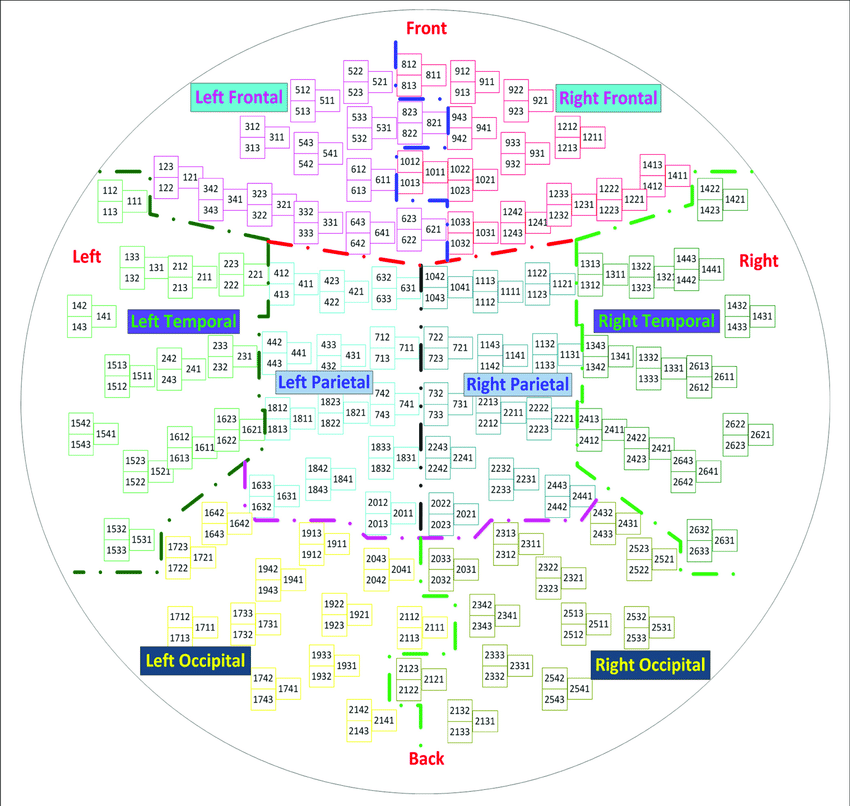


**问题2：** 绘制一些噪声传感器的时间过程并与非噪声传感器进行比较。噪声传感器的特征是什么？

绘制几个传感器的时间过程的示例：

In [ ]:
raw1_copy.pick(["MEG2311", "MEG2321" ])
raw1_copy.plot(proj = False)

Using matplotlib as 2D backend.


<MNEBrowseFigure size 1995.59x1239.57 with 5 Axes>

Channels marked as bad:
none


绘制几个传感器的功率谱的示例：

In [10]:
n_fft = 2000
temp_psd = raw1_copy.compute_psd(method="welch", fmin=1, fmax=60,  n_fft=n_fft, n_overlap=int(n_fft/2))
temp_psd.plot();

Effective window size : 2.000 (s)


Plotting power spectral density (dB=True).


**问题3：** 是什么导致了嘈杂的传感器，可以采取措施减少未来数据采集的问题吗？

在数据集中将嘈杂和扁平的传感器设置为“坏”：

In [11]:
raw1.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', raw1.info['bads'])

bads = ['MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG2311']


更改MEGIN磁力计线圈类型（3022型和3023型至3024型），以确保系统之间的兼容性。

In [12]:
raw1.fix_mag_coil_types()

102 of 102 magnetometer types replaced with T3.


<Raw | sub-01_ses-01_task-SpAtt_run-02_meg.fif, 343 x 1434000 (1434.0 s), ~3.67 GiB, data loaded>

## 应用Maxfilter并进行校准

应用执行最大滤波、SSS、校准和串扰减少的算法：

In [13]:
raw1_sss = mne.preprocessing.maxwell_filter(
    raw1,
    cross_talk=crosstalk_file,
    calibration=calibration_file,
    verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG2311']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-01_ses-01_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil orientations by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Using loaded raw data
    Processing 143 data chunks
[done]


绘制原始数据的功率谱：

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/home/ubuntu/miniconda3/envs/torch/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


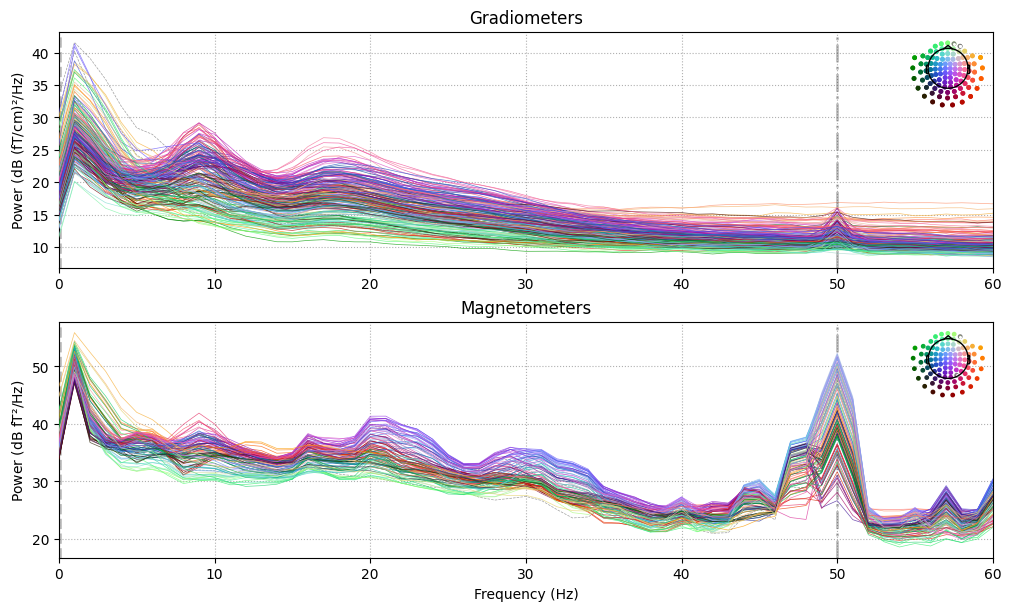

In [14]:
%matplotlib inline
raw1.compute_psd(fmax=60, n_fft=1000).plot();  

并将它们与应用降噪算法之后的功率谱进行比较：

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/home/ubuntu/miniconda3/envs/torch/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


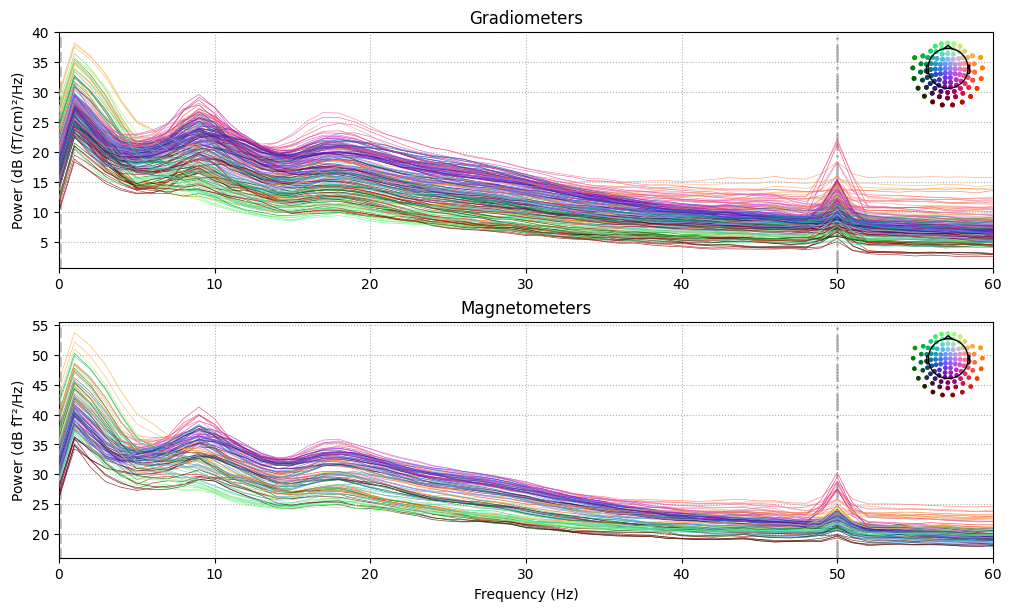

In [15]:
%matplotlib inline
raw1_sss.compute_psd(fmax=60, n_fft=1000).plot();

**问题4:** SSS应用于磁强计50 Hz峰值的结果是什么？降低了50Hz工频干扰，收束舒缓了波形

**问题5:** SSS对梯度计还是磁力计最有效？磁力计

Save the result in a FIF-file:

In [16]:
raw1_sss.save(deriv_file_1, overwrite=True) 

Writing /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif


Closing /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
[done]


[PosixPath('/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif')]

要完成该过程，请对其余子文件执行降噪过程。它们将存储在衍生品文件夹中：

这个示例数据集的'run=01'的meg数据有问题，无法正常加载

In [17]:
bids_path.update(run='01')
print(bids_path.basename)
raw2 = read_raw_bids(bids_path=bids_path, 
                      extra_params={'preload':True},
                      verbose=True)
raw2.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
raw2.fix_mag_coil_types()
raw2_sss = mne.preprocessing.maxwell_filter(raw2,
                                             cross_talk=crosstalk_file,                                          
                                             calibration=calibration_file,
                                             verbose=True)

raw2_sss.save(deriv_file_2, overwrite=True)

sub-01_ses-01_task-SpAtt_run-01_meg.fif
Opening raw data file /home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif...
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 208000 ... 1575999 =    208.000 ...  1575.999 secs
Ready.
Reading 0 ... 1367999  =      0.000 ...  1367.999 secs...


/tmp/ipykernel_713373/3125759213.py:3: RuntimeWarning: Invalid tag with only 0/16 bytes at position 1881971832 in file /home/ubuntu/database/ds004346-FLUX/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
  raw2 = read_raw_bids(bids_path=bids_path,


ValueError: buffer size must be a multiple of element size

## 何时应用以及不应用SSS

SSS算法用于抑制外部噪声源；然而，也有一些缺点。一个问题是SSS显著地降低了数据的秩。当协方差矩阵（例如波束成形方法）很重要时，在执行源建模时，考虑这一点很重要。第二个问题是数据上的宽带噪声可能会增加。当研究事件相关场和30Hz以下振荡的调制时，这本身不是问题。然而，在进行多变量模式分析时，SSS相关的宽带噪声增加可能会带来问题（见Bezudnova等人，出版中）。当计划执行多变量模式或代表性模式分析时，建议使用信号空间投影或均匀场校正，而不是SSS。



## 预注册和发布

预配准：报告采样频率和抗混叠低通滤波器的特性。同时报告要记录的外围数据（例如EOG和ECG）

Publication, example:

"Sensors with excessive artefacts were marked from the data sets using a semi-automatic detection algorithm (about 8 per participant). Subsequently, the Signal-Space Separation (SSS) method  (Taulu et al., 2004) was applied to reduce environmental artefacts. SSS decomposes the data using multiple moments based on spherical harmonics and removes the component of the magnetic field originating from outside the MEG helmet."

“使用半自动检测算法（每个参与者约8个）从数据集中标记出伪影过多的传感器。随后，应用信号空间分离（SSS）方法（Taulu et al.，2004）来减少环境伪影。SSS使用基于球面谐波的多个矩分解数据，并去除源自MEG头盔外部的磁场分量。”

## References

Bezsudnova, Y., Quinn, A., and Jensen, O. (in press) Optimizing magnetometers arrays and analysis pipelines for multivariate pattern analysis. 	J Neurosci Methods

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616

Taulu,S. and Kajola, M. (2005) Presentation of electromagnetic multichannel data: the signal space separation method. Journal of Applied Physics, 97(12):124905 doi:10.1063/1.1935742.

Taulu, S. and Simola, J. (2006) Spatiotemporal signal space separation method for rejecting nearby interference in MEG measurements. Physics in Medicine and Biology, 51(7):1759–1768 doi:10.1088/0031-9155/51/7/008.